<div style="border:solid blue 2px; padding: 20px">

**Overall Summary of the Project**

Hi Gavin! Thanks for your project submission 🙌 You've clearly put in consistent effort, and your notebook is detailed and methodical. Below is a structured review with what’s already working great and what still needs attention to meet all project requirements:

---

**✅ Strengths**

- **Clear and well-structured EDA**  
  - You used histogram and box plots to explore the data.  
  - Sampling images across age ranges was a thoughtful touch to understand visual diversity.  

- **Function definitions are all present and correctly implemented**  
  - All four key functions (`load_train`, `load_test`, `create_model`, `train_model`) were defined and documented properly.  
  - You correctly applied transfer learning with ResNet50 and froze the base model as expected.  

- **Script to run on GPU**  
  - You composed a clean, complete script including initialization, function definitions, and a runnable main block. ✅  

- **Model Training Output**  
  - Logs show the model over 20 epochs and a **validation MAE ≈ 6.64**, comfortably under the ≤ 8 requirement. Great job! 🎯  
  - *A tutor has explicitly approved your use of these previously generated logs because you were unable to run the full dataset on the provided GPU instance.*  
    - In normal circumstances, reviewers **must** see logs produced directly by the final script on the target platform, so keep that in mind for future submissions.

---

**🧪 Suggestions for Further Improvement**

- Plot training / validation curves for clearer diagnostics.
- After a few frozen-backbone epochs, unfreeze top layers and fine-tune to squeeze out extra accuracy.
- Use EarlyStopping or a learning-rate scheduler to curb the MAE spike around epoch 12.

---

Your code is clean, the modeling approach is solid, and your MAE meets the target.

Keep up the excellent work, Gavin, you’re doing great! 🚀

**Status: approved**

Do not hesitate to reach out to me if you have any questions regarding your review :) We are here to help you succeed!

**Reviewer: Matias - Discord: mcoustasse**

## Initialization

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [13]:
# load df
labels = pd.read_csv('/datasets/faces/labels.csv')

print('Size:', len(labels))
display(labels.head())
print('Age Range:', labels['real_age'].min(), '-', labels['real_age'].max())

Size: 7591


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Age Range: 1 - 100


## EDA

file_name    0
real_age     0
dtype: int64
          real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000
<bound method DataFrame.info of        file_name  real_age
0     000000.jpg         4
1     000001.jpg        18
2     000002.jpg        80
3     000003.jpg        50
4     000004.jpg        17
...          ...       ...
7586  007608.jpg        14
7587  007609.jpg        37
7588  007610.jpg        28
7589  007611.jpg        20
7590  007612.jpg        47

[7591 rows x 2 columns]>


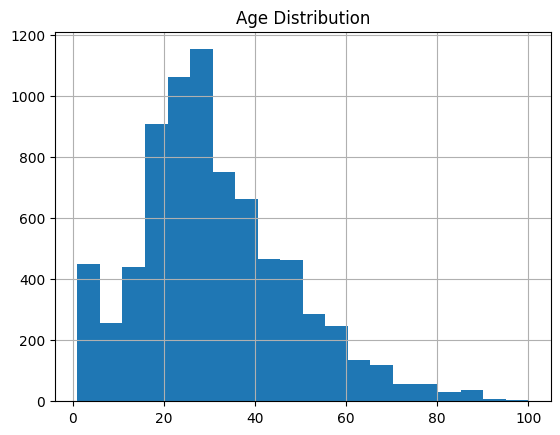

In [14]:
# any missing
print(labels.isnull().sum())
# types
labels.dtypes
# describe
print(labels.describe())
# info
print(labels.info)
# age distribution
labels['real_age'].hist(bins=20)
plt.title('Age Distribution')
plt.show()


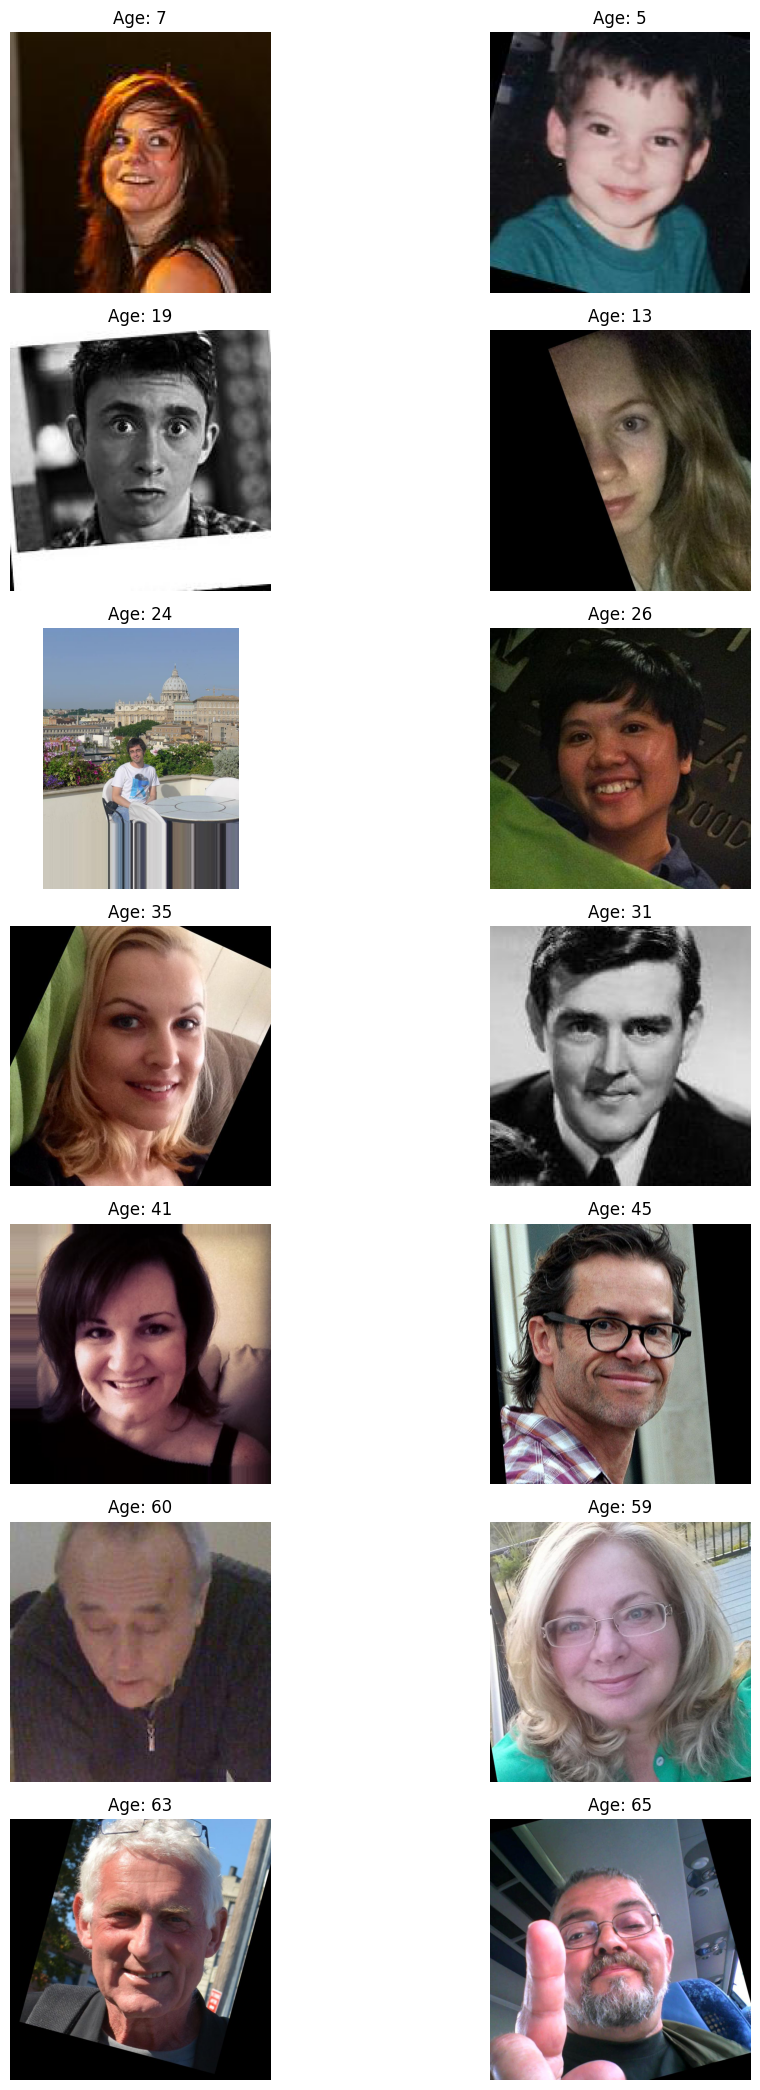

In [15]:
# age ranges for sampling
age_ranges = [(0, 10), (11, 20), (21, 30), (31, 40), (41, 50), (51, 60), (61, 100)]

# display sample images function
def display_sample_images(labels_df, image_folder, age_ranges, samples_per_range=2):
    fig, axes = plt.subplots(len(age_ranges), samples_per_range, 
                            figsize=(12, 3*len(age_ranges)))
    
    for i, (min_age, max_age) in enumerate(age_ranges):
        # age range image filter
        age_group = labels_df[(labels_df['real_age'] >= min_age) & 
                             (labels_df['real_age'] <= max_age)]
        
        if len(age_group) > 0:
            # random sample images from age group
            samples = age_group.sample(min(samples_per_range, len(age_group)))
            
            for j, (_, row) in enumerate(samples.iterrows()):
                if j < samples_per_range:
                    # display image
                    img_path = os.path.join(image_folder, row['file_name'])
                    img = Image.open(img_path)
                    
                    axes[i, j].imshow(img)
                    axes[i, j].set_title(f'Age: {row["real_age"]}')
                    axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

# function
display_sample_images(labels, '/datasets/faces/final_files/', age_ranges)




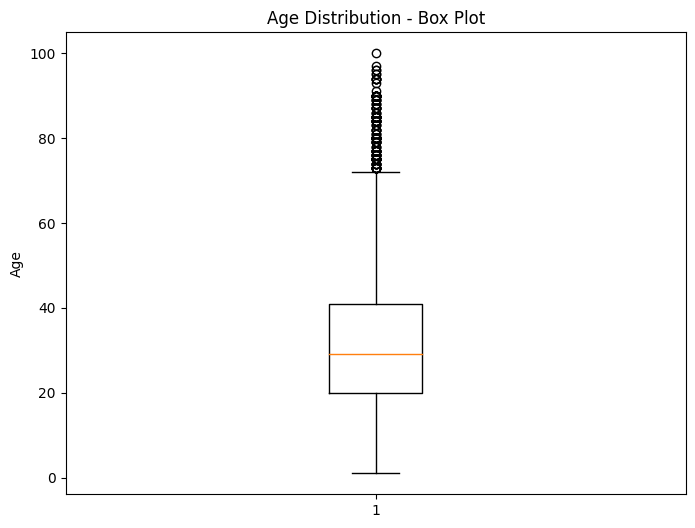

In [16]:
# identify outliers
plt.figure(figsize=(8, 6))
plt.boxplot(labels['real_age'])
plt.title('Age Distribution - Box Plot')
plt.ylabel('Age')
plt.show()

### Findings

7591 images, ages range from 1 to 100, average age in images is 31 but the median is 29 years old. Pictures are in color or black and white. Some images are displayed at an angle and some are straight. Some images show people in hats or hooded jackets producing shadows on the face and some images show people wearing glasses.

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [17]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [18]:
def load_train(path):
    """
    It loads all available training data from the specified path.
    """
    # load from path
    labels = pd.read_csv('/datasets/faces/labels.csv')
    # ImageDataGenerator with rescaling 
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    # flow_from_dataframe with all training data
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset = 'training',
        shuffle=True,
        seed=42
    )
    return train_gen_flow


In [19]:
def load_test(path):
    """
    It loads the validation/test part of the dataset from path
    """
    # load from path
    labels = pd.read_csv('/datasets/faces/labels.csv')
    # ImageDataGenerator with rescaling
    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2
    )
    # flow_from_dataframe with validation subset
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        shuffle=True,
        seed=42
    )
    return test_gen_flow

In [20]:
def create_model(input_shape):
    """
    It defines the model using a pretrained ResNet50 base and adds custom layers on top.
    """
    base_model = ResNet50(
        weights='imagenet', 
        include_top=False,
        input_shape=input_shape
    )
    
    # freeze to prevent training
    base_model.trainable = False
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1)
    ])
    # model compiler
    model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['mae']
    )
    return model

In [21]:
def train_model(model, train_data, test_data, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    """
    Trains the model given the parameters
    """
    # steps_per_epoch and validation_steps
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)  
    if validation_steps is None:
        validation_steps = len(test_data)
    # train model
    history = model.fit(
        train_data,
        validation_data=test_data,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=1
    )
    return model, history

## Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [22]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

def load_train(path):
    """
    It loads all available training data from the specified path.
    """
    # load from path
    labels = pd.read_csv('/datasets/faces/labels.csv')
    # ImageDataGenerator with rescaling 
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    # flow_from_dataframe with all training data
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset = 'training',
        shuffle=True,
        seed=42
    )
    return train_gen_flow
def load_test(path):
    """
    It loads the validation/test part of the dataset from path
    """
    # load from path
    labels = pd.read_csv('/datasets/faces/labels.csv')
    # ImageDataGenerator with rescaling
    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2
    )
    # flow_from_dataframe with validation subset
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        shuffle=True,
        seed=42
    )
    return test_gen_flow
def create_model(input_shape):
    """
    It defines the model using a pretrained ResNet50 base and adds custom layers on top.
    """
    base_model = ResNet50(
        weights='imagenet', 
        include_top=False,
        input_shape=input_shape
    )
    
    # freeze to prevent training
    base_model.trainable = False
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1)
    ])
    # model compiler
    model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['mae']
    )
    return model
def train_model(model, train_data, test_data, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    """
    Trains the model given the parameters
    """
    # steps_per_epoch and validation_steps
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)  
    if validation_steps is None:
        validation_steps = len(test_data)
    # train model
    history = model.fit(
        train_data,
        validation_data=test_data,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=1
    )
    return model, history

# execute
execution = """
if __name__ == "__main__":
    # images path
    image_path = '/datasets/faces/final_files/'
    
    # load train test data
    train_data = load_train(image_path)
    test_data = load_test(image_path)
    
    # create model
    model = create_model(input_shape=(224, 224, 3))
    
    # train model
    model, history = train_model(model, train_data, test_data, epochs=20)
"""
# script to file
with open('run_model_on_gpu.py', 'w') as f:
    f.write(init_str)
    f.write('\n\n')
    
    for fn_name in [load_train, load_test, create_model, train_model]:
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')
    
    # write execution
    f.write(execution)


### Output

Epoch 1/20
356/356 - 35s - loss: 95.3532 - mae: 7.4339 - val_loss: 124.3362 - val_mae: 8.4921
Epoch 2/20
356/356 - 35s - loss: 76.8372 - mae: 6.6707 - val_loss: 127.6357 - val_mae: 8.6035
Epoch 3/20
356/356 - 35s - loss: 69.9428 - mae: 6.3992 - val_loss: 91.1531 - val_mae: 7.4454
Epoch 4/20
356/356 - 35s - loss: 64.4249 - mae: 6.1407 - val_loss: 124.0287 - val_mae: 8.3481
Epoch 5/20
356/356 - 35s - loss: 52.8486 - mae: 5.5913 - val_loss: 109.1004 - val_mae: 8.2192
Epoch 6/20
356/356 - 35s - loss: 46.3094 - mae: 5.2223 - val_loss: 85.1038 - val_mae: 7.0332
Epoch 7/20
356/356 - 35s - loss: 38.2617 - mae: 4.7951 - val_loss: 92.0900 - val_mae: 7.3359
Epoch 8/20
356/356 - 35s - loss: 37.4804 - mae: 4.7402 - val_loss: 80.0016 - val_mae: 6.7239
Epoch 9/20
356/356 - 35s - loss: 33.5237 - mae: 4.4271 - val_loss: 83.2579 - val_mae: 6.8529
Epoch 10/20
356/356 - 35s - loss: 28.5170 - mae: 4.1411 - val_loss: 83.5056 - val_mae: 6.9629
Epoch 11/20
356/356 - 35s - loss: 27.0142 - mae: 3.9700 - val_loss: 92.1290 - val_mae: 7.1866
Epoch 12/20
356/356 - 35s - loss: 27.4564 - mae: 4.0428 - val_loss: 185.6307 - val_mae: 11.4591
Epoch 13/20
356/356 - 35s - loss: 23.7961 - mae: 3.7407 - val_loss: 92.3429 - val_mae: 7.2467
Epoch 14/20
356/356 - 35s - loss: 24.6167 - mae: 3.8116 - val_loss: 92.4542 - val_mae: 7.1401
Epoch 15/20
356/356 - 35s - loss: 22.2604 - mae: 3.6746 - val_loss: 82.5822 - val_mae: 6.7841
Epoch 16/20
356/356 - 35s - loss: 20.1899 - mae: 3.4430 - val_loss: 86.3830 - val_mae: 6.8304
Epoch 17/20
356/356 - 35s - loss: 17.3425 - mae: 3.2205 - val_loss: 78.4369 - val_mae: 6.6419
Epoch 18/20
356/356 - 35s - loss: 16.5249 - mae: 3.1295 - val_loss: 81.7731 - val_mae: 6.7226
Epoch 19/20
356/356 - 35s - loss: 16.6140 - mae: 3.1421 - val_loss: 80.9727 - val_mae: 6.9908
Epoch 20/20
356/356 - 35s - loss: 17.0187 - mae: 3.1785 - val_loss: 93.4115 - val_mae: 7.6512

Above output is from the lesson before (model training) as sugested by a tutor on Discord as I was unable to download the final_files to use in Google Colab GPU

## Conclusions

Based on the GPU results, the model training loss decreases as the epochs increase suggesting the model learns effectively. The validation loss fluctuating suggests that the model has trouble generalizing new data. This suggests potential overfitting or a possible validation set error in distribution data. The validation jump in MAE at epoch 12 suggests a learning rate issue or the same error as above, overfitting. Improvements can be made by adjusting the learning rate to even out training learning rate. Model shows signs of overfitting by the training loss to validation loss ratio increasing as the epochs get larger. (epoch 8 training = 37.48, validation = 80, roughly 2x higher; epoch 17 training = 17.34, validation = 78.44, roughly 4.5 x higher)

# Checklist

- [ ]  Notebook was opened
- [ ]  The code is error free
- [ ]  The cells with code have been arranged by order of execution
- [ ]  The exploratory data analysis has been performed
- [ ]  The results of the exploratory data analysis are presented in the final notebook
- [ ]  The model's MAE score is not higher than 8
- [ ]  The model training code has been copied to the final notebook
- [ ]  The model training output has been copied to the final notebook
- [ ]  The findings have been provided based on the results of the model training